# ResNet usage

To warm up, we are loading images from the web and running `torchvision.models.resnet34` on them.

Next, we run my model, with `torchvision.models.resnet34` weights

Finally, we train my model on `CIFAR10`, and run it on a test set.

In [1]:
%config ZMQInteractiveShell.ast_node_interactivity = 'last_expr_or_assign'

In [2]:
import matplotlib.pyplot as plt
import torch
from einops import rearrange
from torch.utils.data import DataLoader
from torchvision import models
from tqdm.auto import tqdm

from pytorch_from_scratch.p01_ResNet import get_images, my_resnet
import train_resnet

# run on web images

## load images

  0%|          | 0/8 [00:00<?, ?it/s]

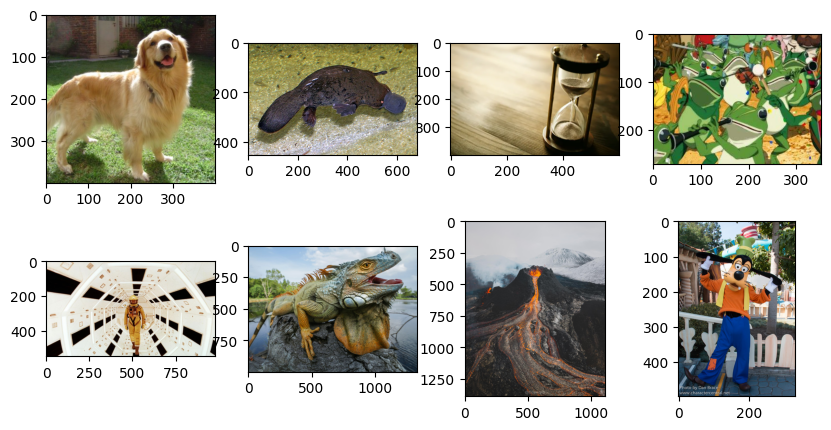

In [3]:
images = get_images.load_all_images()

_fig, axss = plt.subplots(2, 4, figsize=(10, 5))
axs = axss.flatten()
for image, ax in zip(images, axs):
    ax.imshow(image)

### preprocess

  0%|          | 0/8 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.639307].


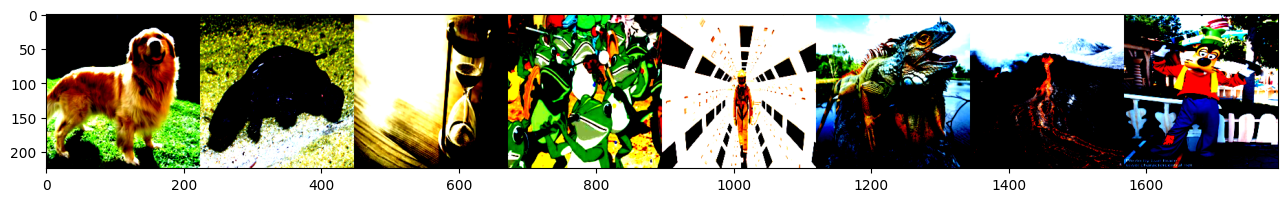

In [4]:
preprocessed_images = get_images.prepare_data(images)

fig, ax = plt.subplots(figsize=(16, 2))
ax.imshow(rearrange(preprocessed_images, "B C H W -> H (B W) C"))

### labels

In [5]:
list(get_images.IMAGENET_LABELS.values())[:10]

['tench, Tinca tinca',
 'goldfish, Carassius auratus',
 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 'tiger shark, Galeocerdo cuvieri',
 'hammerhead, hammerhead shark',
 'electric ray, crampfish, numbfish, torpedo',
 'stingray',
 'cock',
 'hen',
 'ostrich, Struthio camelus']

## run pytorch's ResNet

In [6]:
model = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)

model.eval()
with torch.inference_mode():
    prediction = model(preprocessed_images)

prediction.argmax(dim=-1).tolist()

[207, 103, 604, 865, 628, 39, 980, 447]

In [7]:
def prediction_to_probs(prediction, labels=None, k=3):
    if labels is None:

        def labels(idx):
            return idx

    elif isinstance(labels, dict | list):
        labels = labels.__getitem__

    probs = torch.softmax(prediction, -1)
    top_idxs = prediction.topk(k, dim=-1).indices

    return [
        {labels(int(idx)): float(prob[idx]) for idx in idxs}
        for idxs, prob in zip(top_idxs, probs)
    ]


probs = prediction_to_probs(prediction, get_images.IMAGENET_LABELS)

[{'golden retriever': 0.8181152939796448,
  'Sussex spaniel': 0.021947123110294342,
  'Newfoundland, Newfoundland dog': 0.020913390442728996},
 {'platypus, duckbill, duckbilled platypus, duck-billed platypus, Ornithorhynchus anatinus': 0.999954104423523,
  'electric ray, crampfish, numbfish, torpedo': 2.276264422107488e-05,
  'stingray': 5.535470336326398e-06},
 {'hourglass': 1.0,
  'guillotine': 2.5189801355907093e-09,
  'beaker': 1.8165451365348417e-09},
 {'toyshop': 0.3299645483493805,
  'pinwheel': 0.3109254539012909,
  'comic book': 0.11377470195293427},
 {'liner, ocean liner': 0.21666736900806427,
  'paddlewheel, paddle wheel': 0.10283826291561127,
  'vault': 0.07987731695175171},
 {'common iguana, iguana, Iguana iguana': 0.9760007262229919,
  'frilled lizard, Chlamydosaurus kingi': 0.009088732302188873,
  'agama': 0.0032557828817516565},
 {'volcano': 0.9999028444290161,
  'alp': 3.2112420740304515e-05,
  'mountain tent': 2.5697361706988886e-05},
 {'binoculars, field glasses, ope

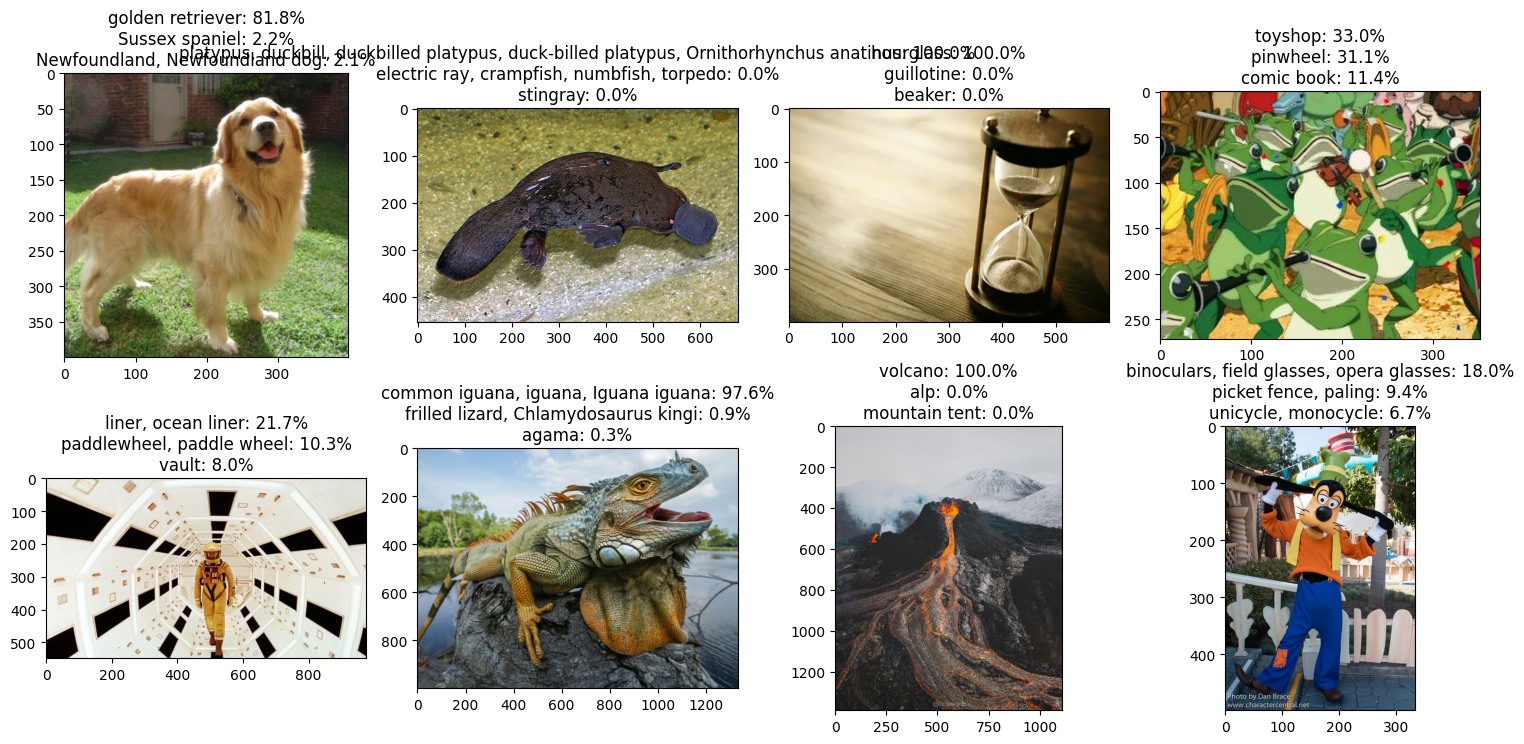

In [8]:
fig, axss = plt.subplots(2, 4, figsize=(15, 7.5))
for image, prob, ax in zip(images, probs, axss.flatten()):
    ax.imshow(image)
    ax.set_title("\n".join(f"{label}: {p:.1%}" for label, p in prob.items()))
fig.tight_layout()

## run my model with pretrained weights

In [9]:
my_model = my_resnet.ResNet34()
orig_model = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
orig_state = orig_model.state_dict()
new_state = dict(zip(my_model.state_dict().keys(), orig_state.values()))
for k in new_state:
    assert new_state[k].shape == my_model.state_dict()[k].shape
my_model.load_state_dict(new_state)

<All keys matched successfully>

In [10]:
# for left, right in zip(orig_model.state_dict(), my_model.state_dict()):
#     print("<", left)
#     print(">", right)
#     print()

In [11]:
my_model.eval()
with torch.inference_mode():
    my_prediction = my_model(preprocessed_images)

my_prediction.argmax(dim=-1).tolist()

[207, 103, 604, 865, 628, 39, 980, 447]

In [12]:
assert my_prediction.argmax(dim=-1).tolist() == prediction.argmax(dim=-1).tolist()

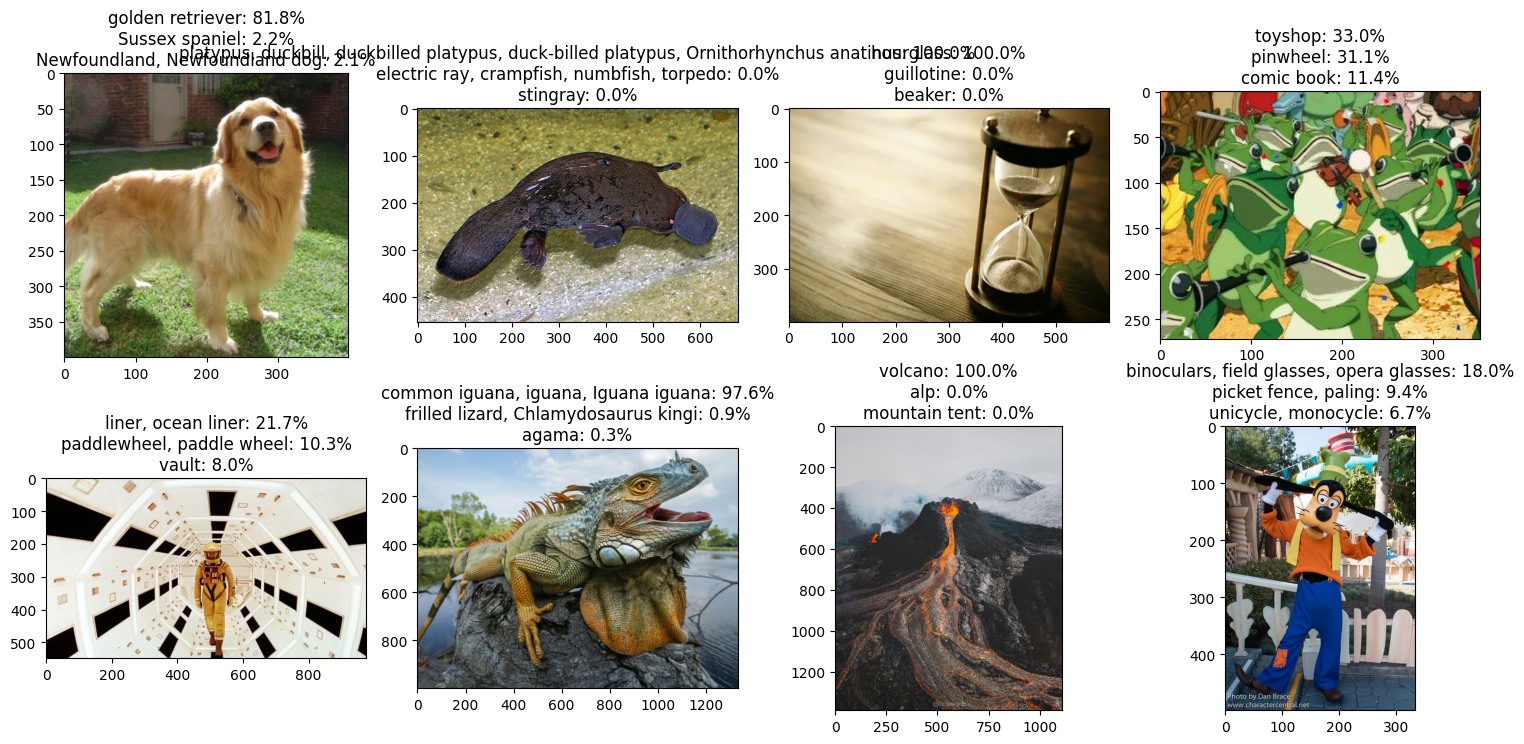

In [13]:
my_probs = prediction_to_probs(my_prediction, get_images.IMAGENET_LABELS)

fig, axss = plt.subplots(2, 4, figsize=(15, 7.5))
for image, prob, ax in zip(images, my_probs, axss.flatten()):
    ax.imshow(image)
    ax.set_title("\n".join(f"{label}: {p:.1%}" for label, p in prob.items()))
fig.tight_layout()

# run on CIFAR10

## load images

In [14]:
cifar_train, cifar_test = get_images.get_cifar10()

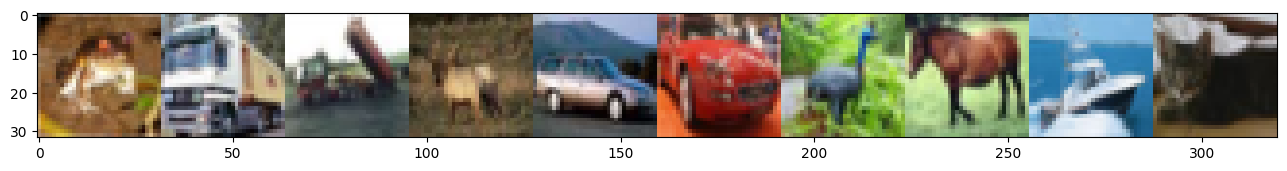

In [15]:
fig, ax = plt.subplots(figsize=(16, 2))
ax.imshow(rearrange(cifar_train.data[:10], "B H W C -> H (B W) C"))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4182546..2.7537313].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.390296..2.4220564].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0219827..1.9325405].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.2352166..2.7537313].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9462504..1.9325405].


Mean value of each channel:  tensor([-0.0520, -0.0408, -0.0137])
Std value of each channel:  tensor([1.2070, 1.2098, 1.3042])


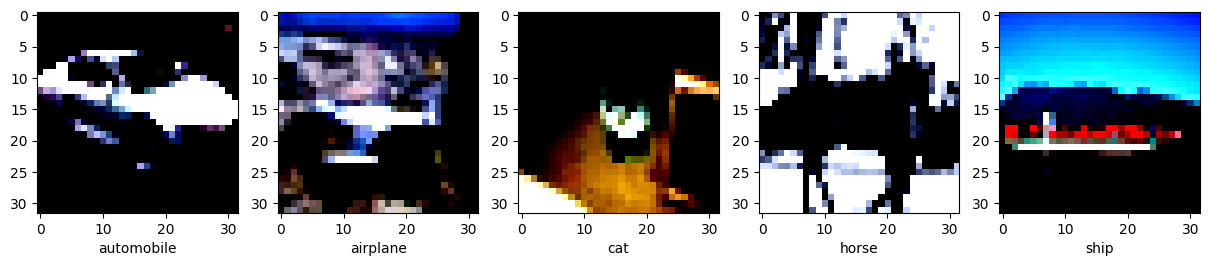

In [16]:
train_loader = DataLoader(cifar_train, batch_size=128, pin_memory=0, shuffle=True)
test_loader = DataLoader(cifar_test, batch_size=128, pin_memory=0)

batch = next(iter(train_loader))
print("Mean value of each channel: ", batch[0].mean((0, 2, 3)))
print("Std value of each channel: ", batch[0].std((0, 2, 3)))

_fig, axss = plt.subplots(ncols=5, figsize=(15, 5), squeeze=False)
axes = axss.flatten()
for i, ax in enumerate(axes):
    ax.imshow(rearrange(batch[0][i], "c h w -> h w c"))
    ax.set(xlabel=get_images.CIFAR_LABELS[batch[1][i].item()])

## train model

In [17]:
if not train_resnet.MODEL_FILENAME.exists():
    trained_model = my_resnet.ResNet34(n_classes=10)
    train_resnet.train(trained_model, train_loader, epochs=8)
    # the model is saved after each epoch

## load trained model

In [18]:
assert train_resnet.MODEL_FILENAME.exists()

trained_model = torch.load(train_resnet.MODEL_FILENAME, weights_only=False)

ResNet34(
  (blocks): Sequential(
    (00_Conv2d): Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3)
    (01_BatchNorm2d): BatchNorm2d(num_features=64, eps=1e-05, momentum=0.1)
    (02_ReLU): ReLU()
    (03_MaxPool2d): MaxPool2d(kernel_size=3, stride=2, padding=1)
    (04_BlockGroup): BlockGroup(
      (blocks): Sequential(
        (00_ResidualBlock): ResidualBlock(
          (left_branch): Sequential(
            (00_Conv2d): Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
            (01_BatchNorm2d): BatchNorm2d(num_features=64, eps=1e-05, momentum=0.1)
            (02_ReLU): ReLU()
            (03_Conv2d): Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
            (04_BatchNorm2d): BatchNorm2d(num_features=64, eps=1e-05, momentum=0.1)
          )
          (right_branch): Sequential()
          (combine): ReLU()
        )
        (01_ResidualBlock): ResidualBlock(
          (left_branch): Sequential(


## run on test set

In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu"

trained_model.eval()
loss_fn = torch.nn.CrossEntropyLoss(reduction="sum")
with torch.inference_mode():
    n_correct = 0
    n_total = 0
    loss_total = 0.0
    for x, y in tqdm(test_loader):
        x = x.to(device)
        y = y.to(device)
        with torch.autocast(device):
            y_hat = trained_model(x)
            loss_total += loss_fn(y_hat, y).item()
        n_correct += y_hat.argmax(dim=-1).__eq__(y).sum().item()
        n_total += len(x)
print(f"Test accuracy: {n_correct} / {n_total} = {100 * n_correct / n_total:.2f}%")
print(f"Test loss: {loss_total / n_total}")

  0%|          | 0/79 [00:00<?, ?it/s]

Test accuracy: 7217 / 10000 = 72.17%
Test loss: 0.8999050953865051


After eight epochs, it achieved 75% test accuracy, with train_loss of 0.38 and test_loss of 0.75.
This gap means the model is overfitting.

### show results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9802322e-08..0.9647058].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9802322e-08..0.95686275].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9802322e-08..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9802322e-08..1.0].


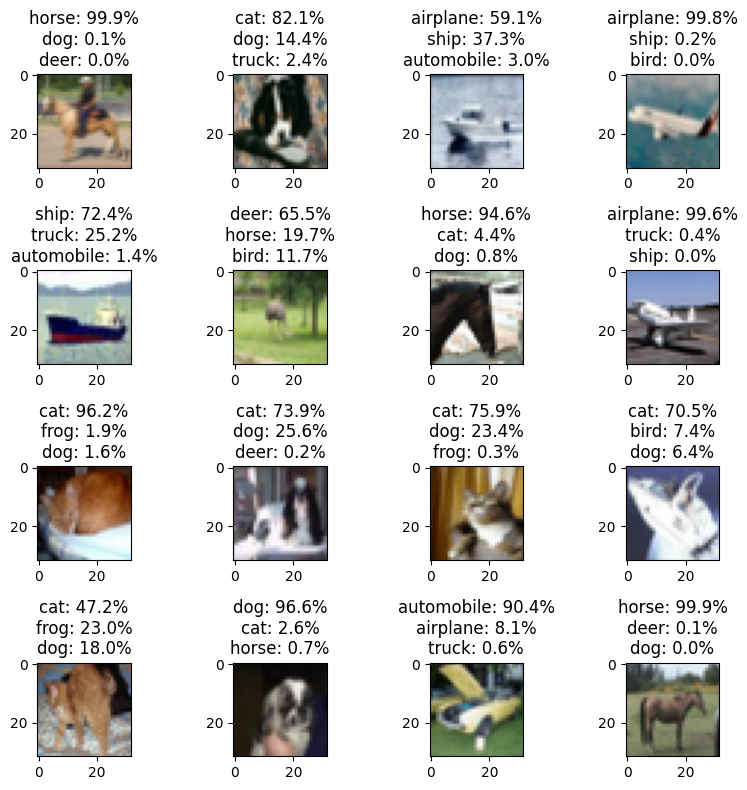

In [20]:
cifar_probs = prediction_to_probs(y_hat, get_images.CIFAR_LABELS)
cifar_images = rearrange(x, "B C H W -> B H W C").cpu() * (
    torch.tensor([51.5865, 50.847, 51.255]) / 255
) + (torch.tensor([125.307, 122.961, 113.8575]) / 255)

fig, axss = plt.subplots(4, 4, figsize=(8, 8))
for image, prob, ax in zip(cifar_images, cifar_probs, axss.flatten()):
    ax.imshow(image.cpu())
    ax.set_title("\n".join(f"{label}: {p:.1%}" for label, p in prob.items()))
fig.tight_layout()